## Подготовим среду и данные для выполнения заданий

### Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

### Загружаем датасет с информацией о медицинских параметрах больных диабетом

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabh00007/diabetescsv")

print("Path to dataset files:", path)

100%|██████████| 8.91k/8.91k [00:00<00:00, 6.19MB/s]

Extracting files...
Path to dataset files: C:\Users\Roman\.cache\kagglehub\datasets\saurabh00007\diabetescsv\versions\1


In [4]:
df = pd.read_csv(path + '/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
target = df['Outcome']
print(f'Размеры датасета: {df.shape}')

Размеры датасета: (768, 9)


In [6]:
X = df.drop('Outcome', axis=1)

# Разделяем на train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, target, test_size=0.2, random_state=42, stratify=target  # сохраняем пропорции классов
)

## 1) Сравним модели логистической регрессии и решающих деревьев

## Обучаем модели

In [7]:
log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

tree_clf = DecisionTreeClassifier(random_state=42)

log_reg.fit(X_train, y_train)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## Оценка стандартных метрик

In [8]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    }

results = pd.DataFrame.from_dict({
    "Logistic Regression": evaluate(log_reg, X_test, y_test),
    "Decision Tree": evaluate(tree_clf, X_test, y_test)
}, orient="index")

results

,Accuracy,Precision,Recall,F1,ROC_AUC
Logistic Regression,0.714286,0.608696,0.518519,0.5600,0.822963
Decision Tree,0.727273,0.642857,0.500000,0.5625,0.675000


### Вывод
По метрике Accuracy обе модели показывают сопоставимые результаты, однако логистическая регрессия значительно превосходит решающее дерево по метрике ROC-AUC (0.823 против 0.675), что говорит о лучшей способности различать классы при разных порогах. Несмотря на немного более высокий Accuracy у решающего дерева, логистическая регрессия обеспечивает более стабильное качество классификации и лучше подходит для данного датасета, особенно с учётом медицинской задачи, где важно качество ранжирования и обобщающая способность модели.

## 2) Исследуем метрики в зависимости от глубины дерева

Я выбрал ROC-AUC, потому что она:
1) Устойчива к дисбалансу классов
2) Учитывает качество ранжирования вероятностей

In [9]:
depths = range(1, 21)
roc_auc_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    roc_auc_scores.append(roc_auc_score(y_test, y_prob))
best_depth = depths[np.argmax(roc_auc_scores)]

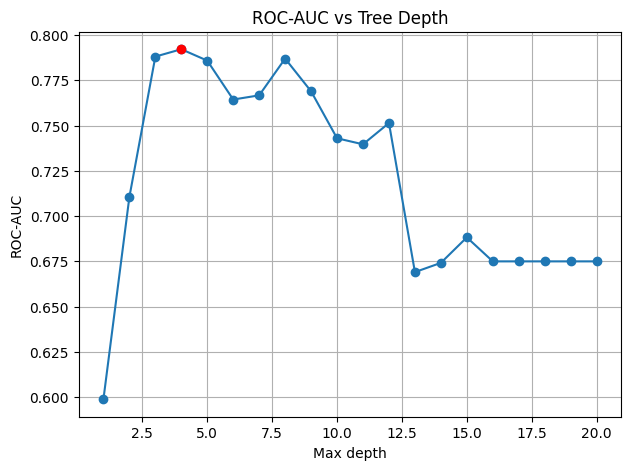

In [10]:
plt.figure(figsize=(7,5))
plt.plot(depths, roc_auc_scores, marker='o')
plt.plot(depths[best_depth-1], roc_auc_scores[best_depth-1], marker='o', color='r')  # Оптимальная глубина
plt.xlabel("Max depth")
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC vs Tree Depth")
plt.grid()
plt.show()

### Глянем ещё на accuracy

Оптимальная глубина: 4
Максимальная точность: 0.7987012987012987


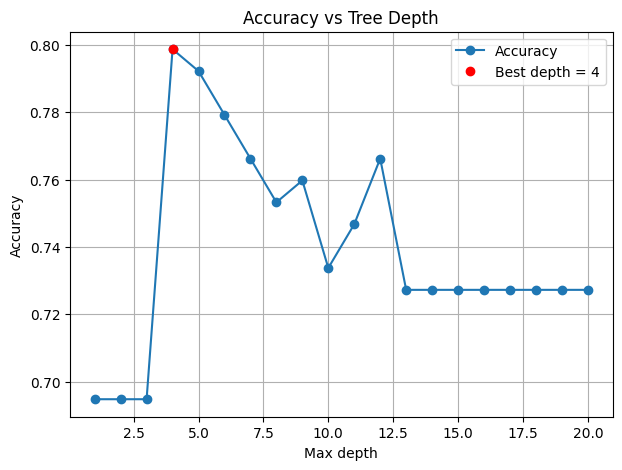

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

depths = range(1, 21)  # рассматриваем глубины от 1 до 20
accuracy_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# находим оптимальную глубину
best_depth = depths[np.argmax(accuracy_scores)]
print("Оптимальная глубина:", best_depth)
print("Максимальная точность:", max(accuracy_scores))

# строим график зависимости accuracy от глубины дерева
plt.figure(figsize=(7,5))
plt.plot(depths, accuracy_scores, marker='o', label="Accuracy")
plt.plot(best_depth, max(accuracy_scores), 'ro', label=f"Best depth = {best_depth}")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Tree Depth")
plt.grid(True)
plt.legend()
plt.show()

## Вывод
Таким образом удалось на примере двух метрик определить оптимальную глубину дерева - 4

## 3) Анализ оптимального дерева

### Обучение модели с оптимальной глубиной

In [12]:
best_tree = DecisionTreeClassifier(
    max_depth=best_depth,
    random_state=42
)
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

### Визуализация дерева

graphviz вызываем множество ошибок, следовательно я использовал альтернативу

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=feature_names,
    class_names=["Healthy", "Sick"],
    filled=True,
    rounded=True,
    max_depth=3              # чтобы дерево не было огромным
)
plt.show()

NameError: name 'feature_names' is not defined

<Figure size 2000x1000 with 0 Axes>

### Важность признаков

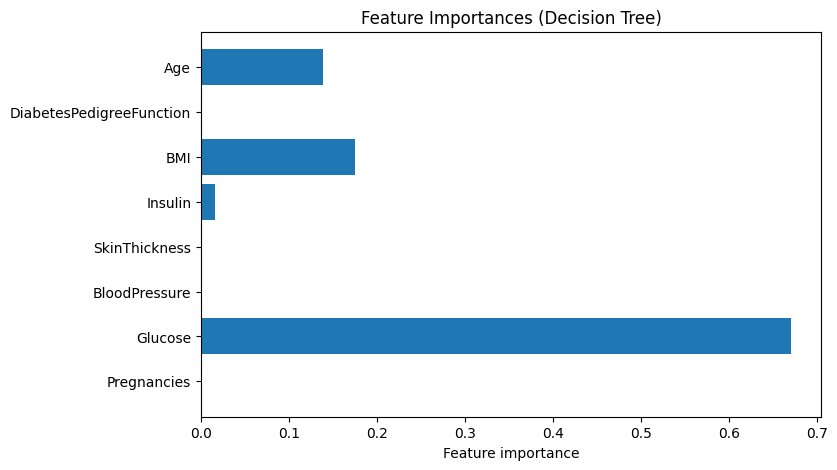

In [14]:
importances = best_tree.feature_importances_

plt.figure(figsize=(8, 5))
plt.barh(X.columns, importances)
plt.xlabel("Feature importance")
plt.title("Feature Importances (Decision Tree)")
plt.show()

### ROC и PR кривые

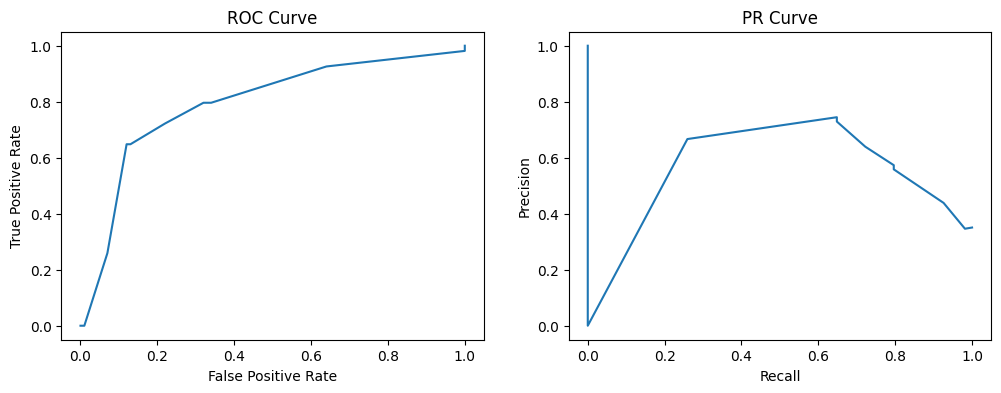

In [15]:
from sklearn.metrics import roc_curve, precision_recall_curve

y_prob = best_tree.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

plt.subplot(1,2,2)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")

plt.show()